## Package import and define parameters

Below, you will define the basic parameters for your database and subcellular structures of interest. You will also initialize the tables in your database to hold the data for your objects of interest.

In general, the sections of this notebook can be run separately from each other. However, you'll want to update and run the parameter defining cell before jumping ahead to other sections. If you get an error stating that something has not been defined, it means you probably need to return to the parameters cell and run it. 


In [2]:
## Define database and structural information

# database info
database_name = 'resubmission'
db_user = "pearlryder"
db_password = ""
db_host = "localhost"

# path to find data

USER_NAME = 'pearlryder'
FILE_PATH = '/Users/' + USER_NAME + '/data/resubmission-data/data'

# Subcellular structures of interest. We recommend keeping all names in letters only 
# and avoiding upper-case letters. You should keep your smFISH images named 'rna'
# These names should match the sub-folders in your data folder
structures = ['rna', 'centrosomes']


# Each structure folder should have two sub-folders, 'raw-data' and 'segmentations'
# You can use different names for these folders if you like -- but update the variables below 
# if you do

raw_data_dir = 'raw-data'
segmentation_dir = 'segmentations'

# If your segmentation files have a different suffix than your raw data files, 
# update the variable below with the suffix
# The suffix below is the suffix that is generated by the Allen Cell Segmenter batch segmentation process
# If your segmentation files have the same suffix as your raw data filenames, then change this variable 
# to an empty string, e.g. segmentation_file_suffix = ''

segmentation_file_suffix = '_struct_segmentation.tiff'


# Update the scale parameters below for the number of microns per pixel in the xy plane and the z plane
xy_scale = 0.065 # microns per pixel in the xy dimension
z_scale = 0.25   # microns between each z step


# here you can create a distance threshold that changes with the nuclear cycle
# the expectation is that you have a column in your images table describing the nuclear stage 
# this threshold is optional and describes how close an RNA object can be to your target of interest
# and still be considered a "true" RNA object (instead of background)

distance_threshold_dict = {
'NC10': 10,
'NC11': 8,
'NC12': 5,
'NC13': 4,
'NC14': 3
}

## Object data extraction

These cells extracts basic data about the subcellular structure objects and insert it into the postgres database.

**Note that images are not reprocessed.**

If you need to delete object data for a structure in a particular image, use the `delete_data_db(image_name, structure, conn)` function

In a new cell, you would run:
```bash
from pipeline import delete_data_db
conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)
image_name = ''
structure = ''
delete_data_db(image_name, structure, conn)
conn.close()
```
Update the image_name and structure variables with the respective image names and structures.

In [ ]:
# Python package
import os
import psycopg2

# Functions from the pipeline.py module
from pipeline import create_postgres_table, test_data_db, extract_object_properties, insert_object_data


In [ ]:
# This cell creates postgres tables to hold data for the structures of interest
# Table names are automatically assigned based on your structures of interest


conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)

for structure in structures:
    create_postgres_table(conn, structure)

conn.close()

In [ ]:
# This cell navigates through the files in your data directories and extracts basic object data such as 
# area and integrated intensity for each structure 

for structure in structures:
    print(structure)
    segmentations_path = os.path.join(FILE_PATH, structure, segmentation_dir)

    for seg_img_name in os.listdir(segmentations_path):
        if not seg_img_name[0] == '.':

            ins_img_name = seg_img_name

            if segmentation_file_suffix:
                ins_img_name = seg_img_name[0:-(len(segmentation_file_suffix))] + '.tif'

            # check if the image has been processed

            
            if test_data_db(ins_img_name, structure, database_name, db_user, db_password, db_host):
                print('{structure} data for {image_name} has already been processed and will not be re-processed'.format(structure=structure, image_name=ins_img_name))
                conn.close()

            else:
                seg_img_path = os.path.join(segmentations_path, seg_img_name)
                ins_img_path = os.path.join(FILE_PATH, structure, raw_data_dir, ins_img_name)

                # extract the object properties for that image
                object_data_list = extract_object_properties(seg_img_path, ins_img_path, ins_img_name, xy_scale, z_scale)

                # save data to database
                insert_object_data(structure, object_data_list, database_name, db_user, db_password, db_host)

## Measure distances between two subcellular structures

Below, you will define two subcellular structures. Structure 1 is the "object of interest." For a given image, each structure 1 object will be measured for how far it is to each structure 2 object in the same image. The closest structure 2 object will be identified and the distance to that object will be recorded in the database. 

You will define which objects you are interested in distance measurements for. Do you want to know how far away the RNA is from the closest centrosome, nucleus, etc? If you want to do measure distances from RNA to more than one subcellular object, then you would repeat this process in a separate cell.


In [ ]:
# Measured distances on EC2 using measure_distance.py


## Create images table



In [ ]:
# define parameters

# path to the directory containing your csv file
USER_NAME = 'pearlryder'
csv_dirpath = '/Users/' + USER_NAME + '/data/resubmission-data/data'


# name of your csv file
csv_name = 'resubmission-metadata.csv'



In [ ]:
# import packages

import csv
import os.path
import pandas as pd
import psycopg2


In [ ]:
# get column names from CSV file
csv_filepath = os.path.join(csv_dirpath, csv_name)

with open(os.path.join(csv_filepath), 'r') as f:
    d_reader = csv.DictReader(f)

    #get fieldnames from DictReader object and store in list
    column_names = d_reader.fieldnames

print(column_names)

In [ ]:
csv_file_df = pd.read_csv(csv_filepath)

csv_file_df.head(20)

In [ ]:
csv_file_df['name'] = csv_file_df['name'].apply(lambda x: x[0:-4] + '.tif')

csv_file_df.head(20)


In [ ]:
# save as csv 
csv_file_df.to_csv(csv_filepath, index = False)



In [ ]:
# code to create a new table:
# update the column names below to match the column names in your .csv file (printed out above)
# if these column names don't match your table columns in the database, then the copy statement below will fail


# THIS QUERY NEEDS TO BE EDITED!
create_table_query = """CREATE TABLE IF NOT EXISTS images (name TEXT NOT NULL,
                                                            rna TEXT,
                                                            stage TEXT,
                                                            cycle TEXT);"""


print(create_table_query)


In [ ]:
# this code runs the query that you edited above. If you get an error that
# 'create_table_query' is not defined, then you need to run the cell above

conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)

cur = conn.cursor()
cur.execute(create_table_query)

conn.commit()

cur.close()
conn.close()


In [ ]:
# now copy the data in and add an id column

copy_query = """COPY images
            FROM %(csv_filepath)s DELIMITER ',' CSV HEADER;"""

csv = os.path.join(csv_filepath, csv_name)


conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)

cur = conn.cursor()
cur.execute(copy_query, {'csv_filepath': csv_filepath})
conn.commit()

add_id_column = "ALTER TABLE images ADD COLUMN IF NOT EXISTS id SERIAL PRIMARY KEY;"
cur.execute(add_id_column)
conn.commit()

cur.close()
conn.close()


## Normalize RNA to estimate number of single molecules per object

Here we estimate the number of molecules of RNA per object. We take advantage of the postgres database to calculate the average intensity of a small molecule of RNA (defined by the lower_threshold and upper_threshold parameters). 

We recommend including a column named 'rna_type' to describe the type of RNA that each image contains. 


In [ ]:

# name of the table that contains your RNA data. 
rna_table = 'rna'

# the average integrated intensity is calculated for each rna_type
rna_type_column = 'rna'

# these thresholds identify small objects of RNA using the area feature
# of each object
lower_threshold = 20
upper_threshold = 100



In [ ]:
# import packages
import psycopg2
from psycopg2 import sql

In [ ]:
# first add a column for the normalized intensity data to your structure table of interest


add_normalized_col = sql.SQL("ALTER TABLE {rna_table} ADD COLUMN IF NOT EXISTS normalized_intensity REAL;").format(
                                    rna_table = sql.Identifier(rna_table))

conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)
cur = conn.cursor()

cur.execute(add_normalized_col)
conn.commit()
cur.close()
conn.close()

In [ ]:
# get the RNA types from the database

rna_type_query = sql.SQL("SELECT DISTINCT ({rna_type_column}) FROM images;").format(rna_type_column=sql.Identifier(rna_type_column))

conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)
cur = conn.cursor()

cur.execute(rna_type_query)
rna_types =  [rna_type[0] for rna_type in cur.fetchall()]

cur.close()
conn.close

print('The RNA types in your database are:\n' + str(rna_types))

In [ ]:
# this query calculates the average total intensity of objects between the upper and lower thresholds set in the 
# parameters column. It then divides every value in the total intensity column by this average and sets the 
# normalized intensity column to this result


for rna_type in rna_types:
    normalization_sql = sql.SQL("""UPDATE {rna_table} 
    SET normalized_intensity = total_intensity / 
    (SELECT avg({rna_table}.total_intensity) FROM {rna_table}
                                                    INNER JOIN images 
                                                    ON {rna_table}.name = images.name 
                                                    WHERE images.{rna_type_column} = %(rna_type)s
                                                    AND rna.area >= %(lower_threshold)s
                                                    AND rna.area < %(upper_threshold)s) 
    FROM images 
    WHERE {rna_table}.name = images.name 
    AND images.{rna_type_column} = %(rna_type)s 
    AND rna.area >= %(lower_threshold)s;""").format(rna_table=sql.Identifier(rna_table),
                                                   rna_type_column=sql.Identifier(rna_type_column))
    
    conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)
    cur = conn.cursor()
    
    cur.execute(normalization_sql, {'rna_type' : rna_type, 'lower_threshold': lower_threshold, 'upper_threshold': upper_threshold})
    conn.commit()
    cur.close()
    conn.close()


## Calculate cumulative % RNA and % RNA in granules

In this section, we calculate the cumulative distribution of RNA relative to the distance from a subcellular structure of interest. As in the distance measurements section, we define structure_1 as the "object of interest" (in most cases, this will be your RNA data) and structure_2 as the "target object." 

This workflow will calculate the % of total RNA and % of total RNA in granules at 0 microns and then at regular intervals defined by the "step_size" parameter up to the distance threshold, if you choose to use a distance threshold. For example, if distance_threshold = 5 and the step_size = 0.05, then this code will calculate the % RNA and % RNA in granules at 0, 0.05, 0.10, 0.15 microns, etc., up to 5 microns for each image.

If you choose not to define an upper distance threshold, then the % of RNA is calculated at intervals defined by the step size from 0 microns up to the maximum distance_from_structure_2 for each image.


In [14]:
# package import
import psycopg2
import os

# local packages
from pipeline import calculate_distributions_by_image_per_cycle, save_csv

In [17]:
# define parameters

# update the strings that describe your object of interest and target objects
structure_1 = 'rna'
structure_2 = 'centrosomes'

# update the column name in your images table that holds data for your image names
image_name_column = 'name'

# update the name of the column in your images table that holds the stage data
stage_column = 'stage'

# the step size between % RNA measurements; in microns
step_size = 0.05

# parameters for saving data. Default is to save in the directory containing your raw-data
# and segmentations in a folder named data within a folder named output 

csv_output_dir = os.path.join('/Users/' + USER_NAME + '/data/resubmission-data/', 'output', 'data')

print("The directory where distribution data will be saved is:\n" + csv_output_dir)

The directory where distribution data will be saved is:
/Users/pearlryder/data/resubmission-data/output/data


In [ ]:
# make an output directory if it doesn't already exist

if not os.path.isdir(csv_output_dir):
    os.makedirs(csv_output_dir)


In [ ]:
# make a thresholds table w/ the for the distance thresholds

# only run this once or you'll get duplicate entries

create_thresholds_table_sql = """CREATE TABLE IF NOT EXISTS thresholds (stage TEXT,
                                                                        maximum_distance INT);"""

insert_thresholds_sql = """INSERT INTO thresholds (stage, maximum_distance) VALUES ('NC10', 10), ('NC11', 8), ('NC12', 5), ('NC13', 4), ('NC14', 3);"""


conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)
cur = conn.cursor()
    
cur.execute(create_thresholds_table_sql)
conn.commit()

cur.execute(insert_thresholds_sql)
conn.commit()

cur.close()
conn.close()


In [ ]:
# calculate the sum of RNA at 0 microns, 0 > RNA <= 1, and > 1 microns
# then save this for plotting in Prism


distance_data = """SELECT rna.name, 
i1mages.rna,
images.stage,
images.cycle,
sum(CASE WHEN distance_to_centrosomes = 0 THEN normalized_intensity ELSE 0 END) / (sum(CASE WHEN rna.distance_to_centrosomes <= thresholds.maximum_distance THEN normalized_intensity ELSE 0 END)) * 100 as zero_micron,
sum(CASE WHEN distance_to_centrosomes > 0 and distance_to_centrosomes <=1 THEN normalized_intensity ELSE 0 END) / (sum(CASE WHEN rna.distance_to_centrosomes <= thresholds.maximum_distance THEN normalized_intensity ELSE 0 END)) * 100  as one_micron, 
sum(CASE WHEN distance_to_centrosomes > 1 and distance_to_centrosomes <= thresholds.maximum_distance THEN normalized_intensity ELSE 0 END) / (sum(CASE WHEN rna.distance_to_centrosomes <= thresholds.maximum_distance THEN normalized_intensity ELSE 0 END)) * 100 as greater_than_1_micron
FROM rna  
INNER JOIN images on rna.name = images.name
INNER JOIN thresholds on images.stage = thresholds.stage
GROUP BY rna.name, images.rna, images.stage, images.cycle;"""

conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)
cur = conn.cursor()

cur.execute(distance_data)
distance_data = cur.fetchall()

cur.close()
conn.close()



In [ ]:
distance_df = pd.DataFrame(distance_data, columns=['name', 'rna', 'stage', 'cycle','percent_0', 'percent_0_to_1', 'percent_greater_than_1'])

distance_df.head()


In [ ]:
NC13_df = distance_df.loc[distance_df['stage'] == 'NC10']

NC13_df_melted = pd.melt(NC13_df, id_vars = ['name', 'rna', 'stage', 'cycle'], value_vars = ['percent_0', 'percent_0_to_1', 'percent_greater_than_1'], var_name='volume', value_name='percent')
NC13_df_melted['rna cycle volume'] = NC13_df_melted['rna'] + ' ' + NC13_df_melted['cycle'] + ' ' + NC13_df_melted['volume']
NC13_df_melted.drop(columns = ['name', 'rna', 'stage', 'cycle', 'volume'], inplace=True)
NC13_df_melted.sort_values(by='rna cycle volume', inplace=True, ignore_index=True)

NC13_pivoted = NC13_df_melted.pivot(columns='rna cycle volume', values='percent')

NC13_pivoted.head(10)

In [ ]:
distribution_data_filename = 'NC10-percent-data.csv'

save_csv(distribution_data_filename, csv_output_dir, NC13_pivoted)


In [ ]:
# select images table column names and images data from database

column_name_query = "SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'images';"

image_name_query = "SELECT * FROM images;"

conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)
cur = conn.cursor()

cur.execute(column_name_query)
column_names =  [column_name[0] for column_name in cur.fetchall()]

cur.execute(image_name_query)
image_data =  cur.fetchall()

cur.close()
conn.close

# process the images data into format needed for rna_distribution calculation
# this will create a list of dictionaries that contain 'column_name' : field
# one row is converted into one dictionary in the list

image_data_list = []

for row_data in image_data:
    image_data_dict = {}
    
    for column_name in column_names:
        idx = column_names.index(column_name)
        
        image_data_dict[column_name] = row_data[idx]
        
    image_data_list.append(image_data_dict)
    
print('The names of the columns in your images table are:\n ' + str(column_names))

In [ ]:
# this cell calculates the percent distribution of total RNA and RNA in granules from 0.0 microns to the 
# distance threshold specified by the user. The data is contained in a dataframe object 

conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)

%time rna_distribution_df = calculate_distributions_by_image_per_cycle(image_data_list, distance_threshold_dict, step_size, image_name_column, stage_column, structure_1, structure_2, conn)

conn.close()

In [ ]:
# this cell reveals the top of the RNA distribution dataframe
# verify that you have the expected columns

rna_distribution_df.head(10)


In [ ]:
# this cell saves the distributions data to a file named distributions.csv 
# in an automatically created "output/data" folder in your data folder
# you can change the name of the file name in the first line of this cell
# this cell WILL NOT overwrite data

distribution_data_filename = 'distributions.csv'

save_csv(distribution_data_filename, csv_output_dir, rna_distribution_df)


In [15]:
### import data for plotting normalized intensity relative to distance


granule_data_sql = """SELECT images.rna, images.stage, images.cycle, rna.distance_to_centrosomes, rna.normalized_intensity 
                    FROM images 
                    INNER JOIN rna on images.name = rna.name
                    INNER JOIN thresholds on images.stage = thresholds.stage
                    WHERE distance_to_centrosomes <= thresholds.maximum_distance;"""


conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)
cur = conn.cursor()

cur.execute(granule_data_sql)
granule_data = cur.fetchall()

cur.close()
conn.close()


granule_df = pd.DataFrame(granule_data, columns = ['rna', 'stage', 'cycle', 'distance', 'granule_count'])

granule_df.head()

,rna,stage,cycle,distance,granule_count
0,cyclin_b,NC13,interphase,3.635940,1.510850
1,cyclin_b,NC13,interphase,3.635940,1.510850
2,cyclin_b,NC13,interphase,3.618700,2.010900
3,cyclin_b,NC13,interphase,3.618700,2.010900
4,gapdh,NC13,metaphase,0.977164,0.849285


In [18]:
# save for plotting w/ seaborn
granule_data_filename = 'distance-normalized_intensity.csv'

save_csv(granule_data_filename, csv_output_dir, granule_df)


Data already saved and will not be saved again


In [24]:
# reorganize data for plotting w/ prism

NC13_df = granule_df.loc[granule_df['stage'] == 'NC13']

NC13_df['rna stage cycle'] = NC13_df['rna'] + ' ' + NC13_df['stage'] + ' ' + NC13_df ['cycle']
NC13_df.drop(columns = ['rna', 'stage', 'cycle'], inplace=True)

NC13_pivoted = NC13_df.pivot(columns='rna stage cycle', values='distance')

NC13_pivoted.head()

/Users/pearlryder/opt/anaconda3/envs/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


rna stage cycle,cen NC13 interphase,cen NC13 metaphase,cg14438 NC13 interphase,cg14438 NC13 metaphase,cyclin_b NC13 interphase,cyclin_b NC13 metaphase,gapdh NC13 interphase,gapdh NC13 metaphase,pins NC13 interphase,pins NC13 metaphase,plp NC13 interphase,plp NC13 metaphase
0,NaN,NaN,NaN,NaN,3.63594,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,3.63594,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,3.61870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,3.61870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.977164,NaN,NaN,NaN,NaN


In [25]:
distribution_data_filename = 'NC13-distance-normalized-intensity.csv'

save_csv(distribution_data_filename, csv_output_dir, NC13_pivoted)


In [ ]:
distance_data = """SELECT rna.name, 
i1mages.rna,
images.stage,
images.cycle,
sum(CASE WHEN distance_to_centrosomes = 0 THEN normalized_intensity ELSE 0 END) / (sum(CASE WHEN rna.distance_to_centrosomes <= thresholds.maximum_distance THEN normalized_intensity ELSE 0 END)) * 100 as zero_micron,
sum(CASE WHEN distance_to_centrosomes > 0 and distance_to_centrosomes <=1 THEN normalized_intensity ELSE 0 END) / (sum(CASE WHEN rna.distance_to_centrosomes <= thresholds.maximum_distance THEN normalized_intensity ELSE 0 END)) * 100  as one_micron, 
sum(CASE WHEN distance_to_centrosomes > 1 and distance_to_centrosomes <= thresholds.maximum_distance THEN normalized_intensity ELSE 0 END) / (sum(CASE WHEN rna.distance_to_centrosomes <= thresholds.maximum_distance THEN normalized_intensity ELSE 0 END)) * 100 as greater_than_1_micron
FROM rna  
INNER JOIN images on rna.name = images.name
INNER JOIN thresholds on images.stage = thresholds.stage
GROUP BY rna.name, images.rna, images.stage, images.cycle;"""


## Graph distribution data

Here we graph the data that was saved in the previous cell


In [3]:
# package imports

import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import os


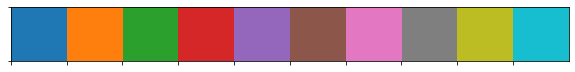

In [4]:
# parameters

distribution_data_filename = 'distributions.csv'
granule_data_filename = 'distance-normalized_intensity.csv'



data_output_dir = os.path.join('/Users/' + USER_NAME + '/data/resubmission-data/', 'output', 'data')

plots_output_dir =  os.path.join('/Users/' + USER_NAME + '/data/resubmission-data/', 'output', 'plots')

sns_palette = sns.color_palette()
sns.palplot(sns_palette)

palette_dict = {'gapdh': sns_palette[0], 
                'cen': sns_palette[1], 
                'plp': sns_palette[2],
                'cyclin_b': sns_palette[3],
               'pins': sns_palette[4],
               'cg14438':sns_palette[9]}


In [5]:
# Here we define a function to save your plots. We choose to save at 600 dpi as .pdf files, which work well with
# Adobe Illustrator files for figure creation. You can change this function so as desired so that your plots will
# be saved consistently

def save_plot(plot_fn, plots_output_dir, plot):
    """ This function takes two strings as inputs and a matplotlib plot object. plot_fn describes the desired filename
    plots_output_dir is the directory to save the plot. plot is a variable containing your plot
    
    This function will not overwrite data
    
    The function tests if a file exists in the plots_output_dir. If a file exists, it prints a message and does nothing
    If a file does not a exist, the plot is saved
    
    Returns nothing
    """
    
    if os.path.isfile(plots_output_dir + '/' + plot_fn):
        print('Plot already saved and will not be saved again')
    else:
        plot.savefig(plots_output_dir + '/' + plot_fn, bbox_inches = 'tight', dpi = 600, format = 'pdf', transparent = True)
        
    return None


In [6]:
# make an output directory if it doesn't already exist

if not os.path.isdir(plots_output_dir):
    os.makedirs(plots_output_dir)



In [6]:
# plotting for granule size relative to distance- NC13 data
# don't use the cyclin B data -- segmentation isn't good enough to make conclusions about granules

granule_distribution_df = pd.read_csv(data_output_dir + '/' + granule_data_filename)

granule_distribution_df = granule_distribution_df.loc[granule_distribution_df['stage'] == 'NC13']

rna_types = ['cg14438', 'plp', 'cen', 'pins']


for rna_type in rna_types:

    granule_distribution_df_gapdh = granule_distribution_df.loc[granule_distribution_df['rna'] == 'gapdh']
    granule_distribution_df_cen = granule_distribution_df.loc[granule_distribution_df['rna'] == rna_type]

    granule_distribution_combined = pd.concat([granule_distribution_df_cen, granule_distribution_df_gapdh])

    g = sns.relplot(x="distance", y="granule_count",
                hue="rna", palette = palette_dict, col="cycle", row= "rna", col_order = ['interphase', 'metaphase'], data=granule_distribution_combined)
    fn = rna_type + '_normalized_intensity_vs_distance_NC13.pdf'
    save_plot(fn, plots_output_dir, g)
    plt.close()


Plot already saved and will not be saved again
Plot already saved and will not be saved again
Plot already saved and will not be saved again
Plot already saved and will not be saved again


In [ ]:
# plotting for granule size relative to distance - NC10 data
# don't use the cyclin B data -- segmentation isn't good enough to make conclusions about granules

granule_distribution_df = pd.read_csv(data_output_dir + '/' + granule_data_filename)

granule_distribution_df = granule_distribution_df.loc[granule_distribution_df['stage'] == 'NC10']

rna_types = ['cen']


for rna_type in rna_types:

    granule_distribution_df_gapdh = granule_distribution_df.loc[granule_distribution_df['rna'] == 'gapdh']
    granule_distribution_df_cen = granule_distribution_df.loc[granule_distribution_df['rna'] == rna_type]

    granule_distribution_combined = pd.concat([granule_distribution_df_cen, granule_distribution_df_gapdh])

    g = sns.relplot(x="distance", y="granule_count",
                hue="rna", palette = palette_dict, col="cycle", row= "rna", col_order = ['interphase', 'metaphase'], data=granule_distribution_combined)
    fn = rna_type + '_normalized_intensity_vs_distance_NC10.pdf'
    save_plot(fn, plots_output_dir, g)
    plt.close()


In [11]:
# make granule plots for figures - only cen data and gapdh data 

granule_distribution_df = pd.read_csv(data_output_dir + '/' + granule_data_filename)

stages = ['NC10', 'NC13']

rna_types = ['cen']

labels = ['_no_label', '_labeled']

for label in labels:

    for stage in stages:
        stage_distribution_df = granule_distribution_df.loc[granule_distribution_df['stage'] == stage]

        for rna_type in rna_types:

            granule_distribution_df_gapdh = stage_distribution_df.loc[granule_distribution_df['rna'] == 'gapdh']
            granule_distribution_df_cen = stage_distribution_df.loc[granule_distribution_df['rna'] == rna_type]

            granule_distribution_combined = pd.concat([granule_distribution_df_cen, granule_distribution_df_gapdh])
            
            g = sns.relplot(x="distance", 
                            y="granule_count",
                            hue="rna", 
                            zorder=10, 
                            palette = {'cen': '#00FDFF', 'gapdh': '#000000'}, 
                            col="cycle", 
                            row= "rna", 
                            col_order = ['interphase', 'metaphase'], 
                            clip_on = False, 
                            data=granule_distribution_combined)


            plt.xlim(-0.15, 10)
            plt.ylim(-15,900)

            for ax in g.axes.flat:
                
                ax.xaxis.set_tick_params(width=2)
                ax.yaxis.set_tick_params(width=2)

                for axis in ['bottom','left']:
                    ax.spines[axis].set_linewidth(2)
                    ax.spines[axis].set_zorder(0)
                if label == '_no_label':
                    ax.xaxis.set_ticklabels([])
                    ax.yaxis.set_ticklabels([])
                    ax.set_ylabel('')
                    ax.set_xlabel('')
                    ax.set_title('')



            fn = rna_type + '_normalized_intensity_vs_distance_' + stage + label + '.pdf'
            save_plot(fn, plots_output_dir, g)
            plt.close()


        

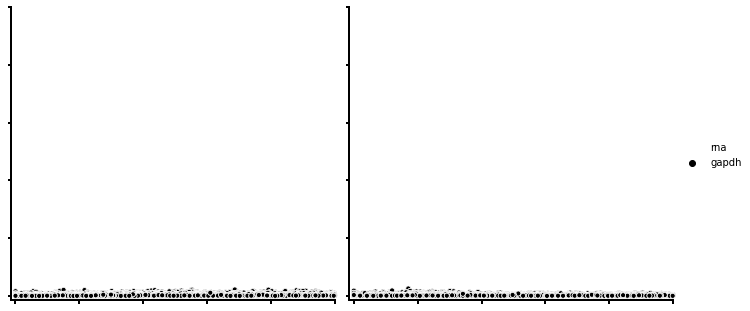

In [28]:
granule_distribution_df = pd.read_csv(data_output_dir + '/' + granule_data_filename)

stage = 'NC13'

stage_distribution_df = granule_distribution_df.loc[granule_distribution_df['stage'] == stage]

granule_distribution_df_gapdh = granule_distribution_df.loc[granule_distribution_df['rna'] == 'gapdh']
granule_distribution_df_cen = granule_distribution_df.loc[granule_distribution_df['rna'] == 'cen']


granule_distribution_combined = pd.concat([granule_distribution_df_cen, granule_distribution_df_gapdh])

granule_distribution_combined.head()

g = sns.relplot(x="distance", 
                y="granule_count",
                hue="rna", 
                zorder=10, 
                palette = {'cen': '#00FDFF', 'gapdh': '#000000'}, 
                col="cycle", 
                row= "rna", 
                col_order = ['interphase', 'metaphase'], 
                edgecolor = '#FFFFFF',
                s = 25,
                clip_on = False, 
                data=granule_distribution_df_gapdh)
plt.xlim(-0.15, 10)
plt.ylim(-15,1000)

label = '_no_label'

for ax in g.axes.flat:

    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)

    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_zorder(0)
    if label == '_no_label':
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title('')


fn = 'gapdh' + '_normalized_intensity_vs_distance_' + stage + label + '_black-circles.pdf'

save_plot(fn, plots_output_dir, g)



In [ ]:
for ax in g.axes.flat:
    if label == '_no_label':
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title('')

    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)


    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_zorder(0)


In [ ]:
# load data from your csv file. This appraoch allows you to avoid re-calculating the distributions each time you 
# want to plot your data, which is time consuming

rna_distribution_df = pd.read_csv(data_output_dir + '/' + distribution_data_filename)

rna_distribution_df['rna stage cycle'] = rna_distribution_df['rna'] + ' ' + rna_distribution_df['stage'] + ' ' + rna_distribution_df['cycle']

NC13_rna_df = rna_distribution_df.loc[rna_distribution_df['stage'] == 'NC13']

NC13_rna_df.head(10)



In [ ]:
# Here we plot the distribution as mean (dark line) +/- sd (shading) using the Seaborn library and matplotlib

# There are a lot of options in Seaborn. In this example, we separate the plots into columns based on the variable 
# "cycle" and adjust the color using the rna_type, in order to compare our experimental RNA (cen) to control (gapdh)


sns.set_style("ticks")
sns.set_context("paper")
percent_rna_plt = sns.relplot(x = 'distance', 
                              y = 'percent_total_rna', 
                              hue = 'rna', 
                              col = 'cycle', 
                              col_order = ['interphase', 'metaphase'], 
                              ci = "sd", 
                              kind="line", 
                              data = NC13_rna_df);

plt.xlim(0)
plt.ylim(0,100)


In [ ]:
NC13_rna_df_melted = pd.melt(NC13_rna_df, id_vars = ['name', 'rna', 'stage', 'cycle', 'rna stage cycle'], value_vars = ['percent_0', 'percent_0_to_1', 'percent_greater_than_1'], var_name='volume', value_name='percent') 

NC13_rna_df_melted.loc[NC13_rna_df_melted['name'] == 'NC12_interphase_Emb4_Img1.nd2']


In [ ]:



y_axis = 'percent'

ax = sns.catplot(x = 'rna stage cycle', 
               y = y_axis, 
               hue = 'volume',
               order = ['cen NC13 interphase', 'cen NC13 metaphase', 'gapdh NC13 interphase', 'gapdh NC13 metaphase'], 
               dodge = True,
                 data = NC13_rna_df_melted,
                kind = "swarm")



#subset_one_micron_total_RNA_fn = stage + '_' + y_axis + label + '_all-interphase-stages-on-one-graph-no-labels.pdf'

#save_plot(subset_one_micron_total_RNA_fn, plots_output_dir, one_micron_granule_RNA_plt)



In [ ]:
ax = sns.boxplot(x = 'rna stage cycle', 
                 y = y_axis, 
                 color = "0.25", 
               order = ['plp NC13 interphase', 'plp NC13 metaphase', 'gapdh NC13 interphase', 'gapdh NC13 metaphase'], 
                 showbox = True, 
                 fliersize = 0, 
                 dodge = False, 
                 data = NC13_rna_df_melted)

# make the boxplot clear and the boundaries black
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

# set the y axis from 0 to 100
plt.ylim(0)

# make the x and y axes visible w/o the top and right frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

labels_bool = True

if not labels_bool:
    # remove labels
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('')

# remove the legend frame
plt.legend(frameon=False)

one_micron_granule_RNA_plt = ax.get_figure()


In [ ]:
# Here we plot the distribution as mean (dark line) +/- sd (shading) using the Seaborn library and matplotlib
# https://seaborn.pydata.org/examples/index.html
# There are a lot of options in Seaborn. In this example, we separate the plots into columns based on the variable 
# "cycle" and adjust the color using the rna_type, in order to compare our experimental RNA (cen) to control (gapdh)


sns.set_style("ticks")
sns.set_context("paper")
percent_rna_plt = sns.relplot(x = 'distance', 
                              y = 'sum_rna', 
                              hue = 'rna',  
                              palette = palette_dict,
                              row='stage',
                              row_order = ['NC10', 'NC11', 'NC12', 'NC13', 'NC14'], 
                              col = 'cycle', 
                              col_order = ['interphase', 'metaphase'], 
                              ci = "sd", 
                              kind="line", 
                              data = rna_distribution_df);

plt.xlim(0)
plt.ylim(0, 100)


In [ ]:
def line_plot(rna_dataframe, y_axis, labels_bool):
    sns.set_style("ticks")
    sns.set_context("paper")
    line_plt = sns.relplot(x = 'distance', 
                                  y = y_axis, 
                                  hue = 'rna', 
                                  palette = palette_dict,
                                  col = 'cycle', 
                                  col_order = ['interphase', 'metaphase'], 
                                  ci = "sd", 
                                  kind="line", 
                                  data = rna_dataframe);

    plt.xlim(0)
    plt.ylim(0, 100)
    
    
    if not labels_bool:
        for ax in line_plt.axes.flatten():
            ax.xaxis.set_ticklabels([])
            ax.yaxis.set_ticklabels([])
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_title('')
    
    return line_plt
    
# Now we repeat the same plotting and saving for the percent granule column:
def swarm_plot(rna_dataframe, y_axis): 
    swarm_plt = sns.catplot(data=one_micron_df, 
                x='rna',
                y=y_axis,
                row='stage',
                row_order=['NC10', 'NC11', 'NC12', 'NC13', 'NC14'],
                col='cycle', 
                hue='rna', 
                kind='swarm',
                palette=palette_dict)

    plt.ylim(0)

    
    return swarm_plt


In [ ]:
rna_distribution_df = rna_distribution_df.loc[rna_distribution_df['stage'] == 'NC13']


In [ ]:
# Here we plot the distribution as mean (dark line) +/- sd (shading) using the Seaborn library and matplotlib
# https://seaborn.pydata.org/examples/index.html
# There are a lot of options in Seaborn. In this example, we separate the plots into columns based on the variable 
# "cycle" and adjust the color using the rna_type, in order to compare our experimental RNA (cen) to control (gapdh)

gapdh_data = rna_distribution_df.loc[rna_distribution_df['rna'] == 'gapdh'] 

rna_types = ['cen', 'plp', 'cg14438', 'pins', 'cyclin_b']

for rna_type in rna_types:

    rna_data = rna_distribution_df.loc[rna_distribution_df['rna'] == rna_type] 


    # subset dataframes
    combined_data = pd.concat([rna_data, gapdh_data])
    less_than_1_micron_distribution_df = combined_data.loc[combined_data['distance'] <= 1] 
    one_micron_df = combined_data.loc[combined_data['distance'] == 1]

    # combine into list of dictionaries
    dataframes = [('_all-data',  combined_data), ('_less-than-1', less_than_1_micron_distribution_df)]

    labels_bool_tuple = (True, False)

    y_axis_ls = ['percent_total_rna', 'percent_granule_rna']

    for y_axis in y_axis_ls:
        print(y_axis)
        
        for (data_type, rna_dataframe) in dataframes:
            
            for labels_bool in labels_bool_tuple:

                if labels_bool == True:
                    label = '_labels_'
                else:
                    label = '_no_labels_'

                sns.set_style("ticks")
                sns.set_context("paper")
                
                #rna_plt = 
                
                rna_plt = line_plot(rna_dataframe, y_axis, labels_bool)

                plt.xlim(0)
                plt.ylim(0,100)

                    
                fn = rna_type + data_type + label + y_axis + '.pdf'
                save_plot(fn, plots_output_dir, rna_plt)
                plt.close()


In [ ]:
# Finally, we sometimes find that we want to capture data for a single distance point
# For example, we might want to get all the data points for what % of RNA is located within 1 micron
# To do this, we change the subset to distance == 1
# Since our dataframe contains cumulative distribution data, this point represents the % RNA / % RNA in granules
# within 1 micron

# subset data to get gapdh and sov data

gapdh_data = rna_distribution_df.loc[rna_distribution_df['rna'] == 'gapdh'] 
sov_data = rna_distribution_df.loc[rna_distribution_df['rna'] == 'cg14438'] 

combined_data = pd.concat([sov_data, gapdh_data])

# now subset to get all 1 micron data for gapdh and cg14438
one_micron_distribution_df = combined_data.loc[combined_data['distance'] == 0] 

one_micron_distribution_df['rna cycle'] = one_micron_distribution_df['rna'] + ' ' + one_micron_distribution_df['cycle']

one_micron_distribution_df['rna stage'] = one_micron_distribution_df['rna'] + ' ' + one_micron_distribution_df['stage']


one_micron_distribution_df.to_csv(os.path.join((FILE_PATH), 'output', 'data') + '/zero-micron-data.csv')

one_micron_distribution_interphase_df = one_micron_distribution_df.loc[one_micron_distribution_df['cycle'] == 'interphase']

# verify that the distance column is all 1.0
one_micron_distribution_df.head()

In [ ]:
y_axis = 'sum_total_rna'

ax = sns.swarmplot(x = 'rna stage', 
               y = y_axis, 
               hue = 'rna', 
               palette = palette_dict,
               order = ['cg14438 NC10', 'gapdh NC10', 'cg14438 NC12', 'gapdh NC12', 'cg14438 NC14', 'gapdh NC14'], 
               data = one_micron_distribution_interphase_df)

ax = sns.boxplot(x = 'rna stage', 
                 y = y_axis, 
                 color = "0.25", 
               order = ['cg14438 NC10', 'gapdh NC10', 'cg14438 NC12', 'gapdh NC12', 'cg14438 NC14', 'gapdh NC14'], 
                 showbox = True, 
                 fliersize = 0, 
                 dodge = False, 
                 data = one_micron_distribution_interphase_df)

# make the boxplot clear and the boundaries black
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

# set the y axis from 0 to 100
plt.ylim(0)

# make the x and y axes visible w/o the top and right frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

labels_bool = True

if not labels_bool:
    # remove labels
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('')

# remove the legend frame
plt.legend(frameon=False)

one_micron_granule_RNA_plt = ax.get_figure()


subset_one_micron_total_RNA_fn = stage + '_' + y_axis + label + '_all-interphase-stages-on-one-graph-no-labels.pdf'

save_plot(subset_one_micron_total_RNA_fn, plots_output_dir, one_micron_granule_RNA_plt)


In [ ]:
def swarm_box_plot(stage_dataframe, y_axis, labels_bool):
    ax = sns.swarmplot(x = 'rna cycle', 
                   y = y_axis, 
                   hue = 'rna', 
                   palette = palette_dict,
                   order = ['cg14438 interphase', 'gapdh interphase', 'cg14438 metaphase', 'gapdh metaphase'],
                   dodge = False, 
                   data = stage_dataframe)

    ax = sns.boxplot(x = 'rna cycle', 
                     y = y_axis, 
                     color = "0.25", 
                     order = ['cg14438 interphase', 'gapdh interphase', 'cg14438 metaphase', 'gapdh metaphase'],
                     showbox = True, 
                     fliersize = 0, 
                     dodge = False, 
                     data = stage_dataframe)

    # make the boxplot clear and the boundaries black
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')

        # iterate over whiskers and median lines
        for j in range(6*i,6*(i+1)):
             ax.lines[j].set_color('black')

    # set the y axis from 0 to 100
    plt.ylim(0,100)

    # make the x and y axes visible w/o the top and right frames
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    if not labels_bool:
        # remove labels
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title('')

    # remove the legend frame
    plt.legend(frameon=False)

    one_micron_granule_RNA_plt = ax.get_figure()
    
    return one_micron_granule_RNA_plt


In [ ]:
# Now we repeat the same plotting and saving for the percent granule column:

labels_bool_ls = [True, False]

y_axis_ls = ['sum_total_rna', 'sum_granule_rna']

stages = ['NC10', 'NC12', 'NC14']



for labels_bool in labels_bool_ls:
    for y_axis in y_axis_ls:
        for stage in stages:
            stage_dataframe = one_micron_distribution_df.loc[one_micron_distribution_df['stage'] == stage]

            subset_one_micron_granule_RNA_plt = swarm_box_plot(stage_dataframe, y_axis, labels_bool)

            if labels_bool:
                label = '_labels_'
            else:
                label = '_no-labels_'

            subset_one_micron_total_RNA_fn = stage + '_' + y_axis + label + '_at_0_micron-0-100-scale.pdf'

            save_plot(subset_one_micron_total_RNA_fn, plots_output_dir, subset_one_micron_granule_RNA_plt)
            plt.close()


In [ ]:
# Here you can save that data if it's not already saved

# name your plot:


In [ ]:
# Now we repeat the same plotting and saving for the percent granule column:

ax = sns.swarmplot(x = 'rna_type', y = 'percent_granule_rna', hue = 'rna_type', dodge = False, data = one_micron_distribution_df)
ax = sns.boxplot(x = 'rna_type', y = 'percent_granule_rna', color = "0.25", showbox = True, fliersize = 0, dodge = False, data = one_micron_distribution_df)

# make the boxplot clear and the boundaries black
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')
    
# set the y axis from 0 to 100
plt.ylim(0,100)

# make the x and y axes visible w/o the top and right frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# remove the legend frame
plt.legend(frameon=False)

subset_one_micron_granule_RNA_df = ax.get_figure()


In [ ]:
# And we can save the granule plot

# name your plot:
subset_one_micron_granule_RNA_fn = 'percent_granule_RNA_at_1_micron.pdf'

save_plot(subset_one_micron_granule_RNA_fn, plots_output_dir, subset_one_micron_granule_RNA_df)


## Save database tables as .csv files

This section gives you the option to save your database tables as .csv files, which allows you to view raw object data using a text editor rather than needing to have a specialized program like postgres.

By default, the data will be saved in the output/db_backups/db_csvs folder. You can change this behavior in the parameters cell

In [ ]:
# package import

import psycopg2
from psycopg2 import sql 
import os


In [ ]:
# parameters 

db_csv_output_dir =  os.path.join(FILE_PATH, 'output', 'db_backups', 'db_csvs')

In [ ]:
# make folders to contain csv files if they do not already exist 

if not os.path.isdir(db_csv_output_dir):
    os.makedirs(db_csv_output_dir)


In [ ]:
# this cell gets the names of the tables you created from the postgres database

select_tables_sql = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';"

conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)
cur = conn.cursor()
cur.execute(select_tables_sql)
table_name_raw = cur.fetchall()
cur.close()
conn.close()

table_names = [table_name[0] for table_name in table_name_raw]

In [ ]:
# this cell copies data from those tables into csv files
# it will overwrite your previously saved files

for table_name in table_names:
    table_fn = table_name + '.csv'
    table_path = os.path.join(db_csv_output_dir, table_fn)

    copy_sql_query = sql.SQL("COPY {table_name} TO STDOUT WITH CSV HEADER").format(table_name = sql.Identifier(table_name))

    conn = psycopg2.connect(database=database_name, user=db_user, password=db_password, host=db_host)
    cur = conn.cursor()


    with open(table_path, 'w') as f_output:
        cur.copy_expert(copy_sql_query, f_output)